In [79]:
import os
import sys
import cv2
import yaml
import joblib
import zipfile
import traceback
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [80]:
def config():
    with open("../../config.yml", "r") as file:
        config_files = yaml.safe_load(file)
        
    return config_files

In [81]:
class PathException(Exception):
    def __init__(self, message):
        super(PathException, self).__init__(message)
        self.message = message

def validate_path(path):
    if os.path.exists(path):
        return path
    else:
        traceback.print_exc()
        raise PathException("{} Path does not exist".capitalize().format(path))
    
    
def dump(value=None, filename=None):
    if (value is not None) and (filename is not None):
        joblib.dump(value, filename)
        
def load(filename=None):
    if filename is not None:
        return joblib.load(filename)

The unzip folder of image saved in ../../data/raw/


10it [00:00, 85.88it/s]
100%|██████████| 2/2 [00:00<00:00, 387.16it/s]

all the dataloaders are saved in # ../../data/processed/


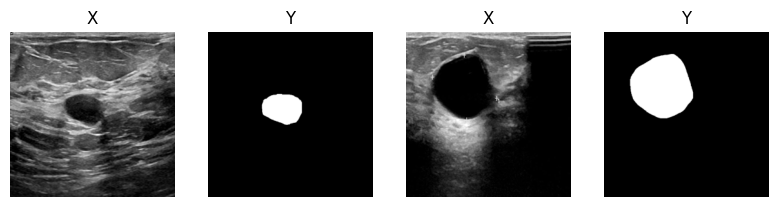

In [82]:
class Loader():
    def __init__(self, image_path = None, channels = 3, image_size = 256, batch_size = 1, split_size = 0.20):
        self.image_path = image_path
        self.channels = channels
        self.image_size = image_size
        self.batch_size = batch_size
        self.split_size = split_size

        self.images = []
        self.masks = []

        self.config = config()

        self.raw_path = validate_path(self.config["path"]["raw_path"])
        self.processed_path = validate_path(self.config["path"]["processed_path"])
        self.files_path = validate_path(self.config["path"]["files_path"])

    def transforms(self):
        return transforms.Compose([
            transforms.Resize((self.image_size, self.image_size), Image.BICUBIC),
            transforms.CenterCrop((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def unzip_folder(self):
        with zipfile.ZipFile(self.image_path, "r") as zip_ref:
            zip_ref.extractall(os.path.join(self.raw_path,))

        print("The unzip folder of image saved in {}".format(self.raw_path))

    def split_dataset(self, X, y):
        if isinstance(X, list) and isinstance(y, list):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.split_size, random_state=42)
            return {
                "X_train": X_train,
                "X_test": X_test,
                "y_train": y_train,
                "y_test": y_test
            }

        else:
            raise ValueError("X and y must be of type list".capitalize())

    def feature_extractor(self):
        self.directory = os.path.join(self.raw_path, "datasets")
        self.images_path = os.path.join(self.directory, "images")
        self.masks_path = os.path.join(self.directory, "masks")

        self.masks_list = os.listdir(self.masks_path)

        for index, image in tqdm(enumerate(os.listdir(self.images_path))):
            image_name, _ = image.split(".")
            mask_name, _ = self.masks_list[index].split(".")

            if image_name == mask_name:
                image_path = os.path.join(self.images_path, image)
                mask_path = os.path.join(self.masks_path, self.masks_list[index])

                image_X = cv2.imread(image_path)
                image_Y = cv2.imread(mask_path)

                image_X = cv2.cvtColor(image_X, cv2.COLOR_BGR2RGB)
                image_Y = cv2.cvtColor(image_Y, cv2.COLOR_BGR2RGB)

                image_X = Image.fromarray(image_X)
                image_Y = Image.fromarray(image_Y)

                image_X = self.transforms()(image_X)
                image_Y = self.transforms()(image_Y)

                self.images.append(image_X)
                self.masks.append(image_Y)

        return self.split_dataset(X=self.images, y=self.masks)

    def create_dataloader(self):
        data = self.feature_extractor()

        self.train_dataloader = DataLoader(
            dataset=list(zip(data["X_train"],data["y_train"])),
            batch_size=self.batch_size,
            shuffle=True
        
        )

        self.test_dataloader = DataLoader(
            dataset=list(zip(data["X_test"], data["y_test"])),
            batch_size=self.batch_size * 8,
            shuffle=True,
        )

        for filename, value in tqdm([("train_dataloader", self.train_dataloader), ("test_dataloader", self.test_dataloader)]):
            dump(
                value=value,
                filename=os.path.join(self.processed_path, "{}.pkl".format(filename))
            )

        print("all the dataloaders are saved in # {}".format(self.processed_path))

    @staticmethod
    def plot_images():
        config_files = config()

        processed_path = validate_path(path=config_files["path"]["processed_path"])
        files_path = validate_path(path=config_files["path"]["files_path"])

        test_dataloader = load(filename=os.path.join(processed_path, "test_dataloader.pkl"))

        image_X, image_Y = next(iter(test_dataloader))

        plt.figure(figsize=(20, 10))

        for index, (image) in enumerate(image_X):
            X = image.permute(1, 2, 0).cpu().detach().numpy()
            Y = image_Y[index].permute(1, 2, 0).cpu().detach().numpy()

            X = (X - X.min())/(X.max() - X.min())
            Y = (Y - Y.min())/(Y.max() - Y.min())

            for idx, (title, value) in enumerate([("X", X), ("Y", Y)]):

                plt.subplot(2 * 2, 2 * 4, 2 * index + idx + 1)
                plt.imshow(value)
                plt.title(title)
                plt.axis("off")

        plt.savefig(os.path.join(files_path, "image.jpeg"))

        plt.show()

    @staticmethod
    def dataset_details():
        config_files = config()

        processed_path = validate_path(path=config_files["path"]["processed_path"])
        files_path = validate_path(path=config_files["path"]["files_path"])
        
        train_dataloader = load(filename=os.path.join(processed_path, "train_dataloader.pkl"))
        test_dataloader = load(filename=os.path.join(processed_path, "test_dataloader.pkl"))
        
        pd.DataFrame(
            {
                "train_image(Total)": str(sum(X.size(0) for X, _ in train_dataloader)),
                "test_image(Total)": str(sum(X.size(0) for X, _ in test_dataloader)),
                "train_image(Batch)": str(train_dataloader.batch_size),
                "test_image(Batch)": str(test_dataloader.batch_size),
                
            },
            index = ["Quantity"]
        ).T.to_csv(os.path.join(files_path, "dataset_details.csv"))


if __name__== "__main__":
    loader = Loader(image_path="/Users/shahmuhammadraditrahman/Desktop/datasets.zip")

    loader.unzip_folder()
    loader.create_dataloader()
    
    loader.plot_images()
    loader.dataset_details()